In [42]:
import pandas as pd
from pyspark.sql import SparkSession
from utils.constants import Paths

In [43]:
spark = SparkSession.builder.appName("SimCity Worker").getOrCreate()

In [44]:
gov_sdf = spark.read.parquet(str(Paths.RAW_DATA_PARQUET / "gov/pothole_gov.parquet"))
user_sdf = spark.read.parquet(str(Paths.RAW_DATA_PARQUET / "user/pothole_311.parquet"))

In [45]:
gov_df = gov_sdf.select('OnPrimName', "RptDate").toPandas()
user_df = user_sdf.select('Street Name', "Created Date").toPandas()

/Users/DonGuest/Code/simcity-smart-cities/simcity_env/lib/python3.11/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/Users/DonGuest/Code/simcity-smart-cities/simcity_env/lib/python3.11/site-packages/pyspark/sql/pandas/types.py:379: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if is_datetime64tz_dtype(s.dtype):
/Users/DonGuest/Code/simcity-smart-cities/simcity_env/lib/python3.11/site-packages/pyspark/sql/pandas/types.py:563: FutureWarning: is_datetime64tz_dtype is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.DatetimeTZDtype)` instead.
  if not is_datetime64tz_dtype(pser.dtype):
/Users/DonGuest/Code/simcity-smart-cities/simcity_env/lib/python3.11/site-packages/pys

In [46]:
spark.stop()

In [47]:
gov_df = gov_df.rename(columns={'OnPrimName' : "street_name", "RptDate" : "created_date"})
user_df = user_df.rename(columns={'Street Name' : "street_name", "Created Date" : "created_date"})

In [48]:
user_df['created_date'] = pd.to_datetime(user_df['created_date'])
user_df['month'] = user_df['created_date'].dt.to_period("M")

gov_df['created_date'] = pd.to_datetime(gov_df['created_date'])
gov_df['month'] = gov_df['created_date'].dt.to_period("M")

In [49]:
gov_df = gov_df[gov_df['created_date'].dt.year >= 2010]

In [50]:
user_complaints_by_street_month = (
    user_df.groupby(['street_name', 'month']).size().reset_index(name='complaints_count')
)

govt_actions_by_street_month = (
    gov_df.groupby(['street_name', 'month']).size().reset_index(name='action_count')
)
merged_df = pd.merge(user_complaints_by_street_month, govt_actions_by_street_month, on=['street_name', 'month'], how='outer')
merged_df = merged_df.fillna(0)

In [51]:
merged_df = pd.merge(user_complaints_by_street_month, govt_actions_by_street_month, on=['street_name', 'month'], how='outer')
merged_df = merged_df.fillna(0)

In [52]:
merged_df['action_delta'] = abs(merged_df['complaints_count'] - merged_df['action_count'])

In [53]:
merged_df = merged_df.sort_values(by='action_delta', ascending=False)

In [54]:
merged_df.to_parquet(Paths.PROCESSED_DATA_PARQUET / "aggregated_pothole.parquet")

In [55]:
from tabulate import tabulate

In [61]:
print(tabulate(merged_df.sort_values(by="action_delta",ascending=False).head(15), headers='keys', tablefmt="psql", showindex=False))

+------------------+---------+--------------------+----------------+----------------+--------+
| street_name      | month   |   complaints_count |   action_count |   action_delta |   year |
|------------------+---------+--------------------+----------------+----------------+--------|
| EAST   31 STREET | 2023-04 |                260 |              0 |            260 |   2023 |
| OCEAN PARKWAY    | 2018-08 |                172 |              7 |            165 |   2018 |
| OCEAN PARKWAY    | 2015-03 |                249 |            105 |            144 |   2015 |
| MC DONALD AVENUE | 2019-03 |                131 |              0 |            131 |   2019 |
| RAMONA AVENUE    | 2022-03 |                124 |              1 |            123 |   2022 |
| FLATBUSH AVENUE  | 2014-05 |                103 |             21 |             82 |   2014 |
| ARTHUR KILL ROAD | 2014-05 |                 95 |             15 |             80 |   2014 |
| SHORE ROAD       | 2016-07 |                 80 

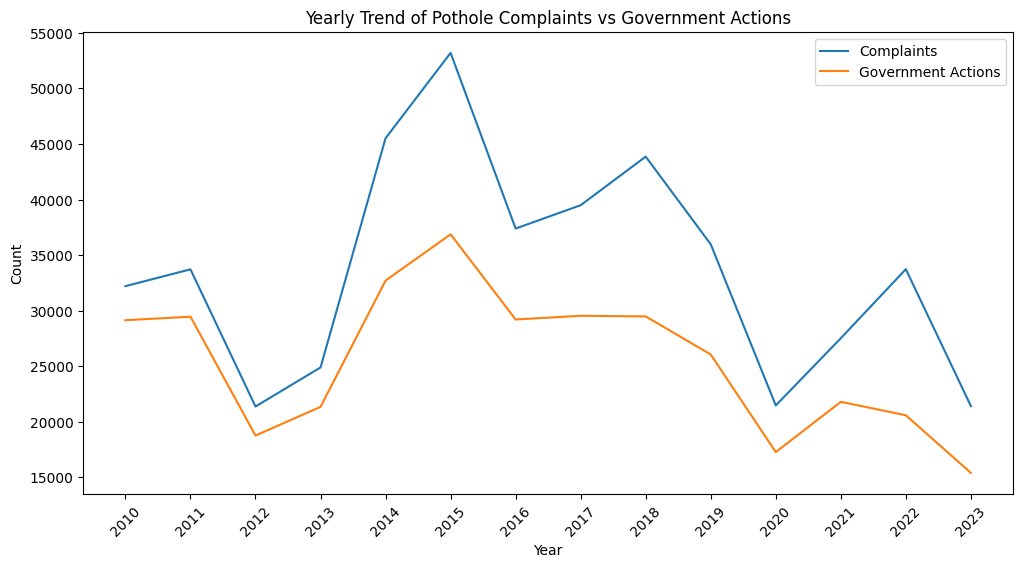

In [60]:
import matplotlib.pyplot as plt

# Extract year from 'month' for aggregation
merged_df['year'] = pd.to_datetime(merged_df['month'].astype(str)).dt.year

# Aggregate data by year
yearly_data = merged_df.groupby('year').agg({'complaints_count': 'sum', 'action_count': 'sum'}).reset_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(yearly_data['year'], yearly_data['complaints_count'], label='Complaints')
plt.plot(yearly_data['year'], yearly_data['action_count'], label='Government Actions')

plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Yearly Trend of Pothole Complaints vs Government Actions')
plt.legend()
plt.xticks(yearly_data['year'], rotation=45)  # Ensure all years are displayed as x-ticks

plt.show()
